In [0]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
import tensorflow as tf

In [18]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


38951745

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [13]:
PATH="/content/gdrive/My Drive/"
with open(os.path.join(PATH+"train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH+"val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
dict_keys(['N_Ko', 'Early_Aramaic', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'Burmese_(Myanmar)', 'Braille', 'Arcadian', 'Asomtavruli_(Georgian)', 'Cyrillic', 'Armenian', 'Latin', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Bengali', 'Japanese_(hiragana)', 'Sanskrit', 'Alphabet_of_the_Magi', 'Tifinagh', 'Korean', 'Balinese', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Anglo-Saxon_Futhorc', 'Greek', 'Gujarati', 'Tagalog', 'Syriac_(Estrangelo)', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Grantha', 'Hebrew', 'Japanese_(katakana)'])
validation alphabets:
dict_keys(['Gurmukhi', 'Angelic', 'Kannada', 'Glagolitic', 'Oriya', 'Atlantean', 'Ge_ez', 'Old_Church_Slavonic_(Cyrillic)', 'Manipuri', 'Keble', 'Aurek-Besh', 'Mongolian', 'ULOG', 'Avesta', 'Atemayar_Qelisayer', 'Malayalam', 'Tengwar', 'Tibetan', 'Sylheti', 'Syriac_(Serto)'])


In [14]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

   
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)

        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
 
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
         
            if i >= batch_size // 2:
                category_2 = category  
            else: 

                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    

loader = Siamese_Loader(PATH)

loading data from /content/gdrive/My Drive/train.pickle
loading data from /content/gdrive/My Drive/val.pickle


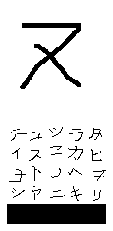

In [15]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

In [20]:
#Training loop
print("!")
evaluate_every = 1 
loss_every=50 
batch_size = 32
n_iter = 5
N_way = 20 
n_val = 250 
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

!
training
4.417943
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 33.6% 20 way one-shot learning accuracy
saving
4.3928876
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.8% 20 way one-shot learning accuracy
4.3513994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.4% 20 way one-shot learning accuracy
4.374496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.8% 20 way one-shot learning accuracy


Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 68.22222222222223% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 66.22222222222223% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 49.55555555555556% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 58.44444444444444% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 5 way one-shot le

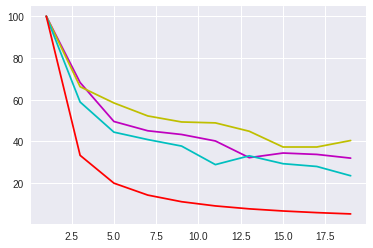

In [24]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 20, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    

plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

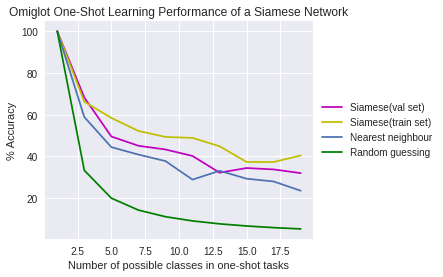

(20, 105, 105, 1)


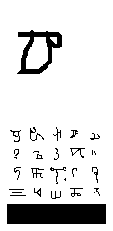

[[0.43027395]
 [0.45033804]
 [0.43004724]
 [0.48908272]
 [0.43937936]
 [0.47825435]
 [0.39271113]
 [0.45173705]
 [0.43468   ]
 [0.46376848]
 [0.4410443 ]
 [0.43744993]
 [0.45238897]
 [0.46051872]
 [0.4465011 ]
 [0.44372252]
 [0.39862984]
 [0.45292112]
 [0.43084982]
 [0.44377622]]


In [25]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)
